In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# No truncation of column content
pd.set_option('display.max_colwidth', None)  

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
FileOut = '../output/'

## EDA

### Загружаем сырые данные

In [4]:
# List files available
print(os.listdir('../../Kaggle/home-credit-default-risk/input/'))

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'HomeCredit_columns_description.ods', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']


In [5]:
# 1.1 Training data
app_train = pd.read_csv('../../Kaggle/home-credit-default-risk/input/application_train.csv')
print('Training data shape: ', app_train.shape)
# app_train.sample(3)
print(app_train.dtypes.value_counts())
print(f"доля пустых значений: {app_train.isnull().sum().sum() / app_train.size}")

Training data shape:  (307511, 122)
float64    65
int64      41
object     16
Name: count, dtype: int64
доля пустых значений: 0.24395941907129431


In [6]:
# 1.2 Test data
app_test = pd.read_csv('../../Kaggle/home-credit-default-risk/input/application_test.csv')
print('Test data shape: ', app_test.shape)
# app_test.sample(3)

Test data shape:  (48744, 121)


In [7]:
targets = app_train['TARGET'].value_counts()
print(f'количество кредитов без просрочек в {targets[0]/targets[1]: .0f} раз превышает количество кредитов с просрочками, т.е. тренировочная выборка не сбалансирована')

количество кредитов без просрочек в  11 раз превышает количество кредитов с просрочками, т.е. тренировочная выборка не сбалансирована


In [8]:
# 2 bureau_df data
bureau_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/bureau.csv')
print('Test data shape: ', bureau_df.shape)
# bureau_df.sample(3)

Test data shape:  (1716428, 17)


In [9]:
# 3 bureau_balance data
bureau_balance_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/bureau_balance.csv')
print('Test data shape: ', bureau_balance_df.shape)
# bureau_balance_df.sample(1)

Test data shape:  (27299925, 3)


In [10]:
# 4 POS_CASH_balance data
POS_CASH_balance_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/POS_CASH_balance.csv')
print('Test data shape: ', POS_CASH_balance_df.shape)
# POS_CASH_balance_df.sample(1)

Test data shape:  (10001358, 8)


In [11]:
# 5 credit_card_balance data
credit_card_balance_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/credit_card_balance.csv')
print('credit_card_balance data shape: ', credit_card_balance_df.shape)
# credit_card_balance_df.sample(1)

credit_card_balance data shape:  (3840312, 23)


In [12]:
# 6 previous_application data
previous_application_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/previous_application.csv')
print('previous_application data shape: ', previous_application_df.shape)
# previous_application_df.sample(1)

previous_application data shape:  (1670214, 37)


In [13]:
# 7 installments_payments data
installments_payments_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/installments_payments.csv')
print('installments_payments shape: ', installments_payments_df.shape)
# installments_payments_df.sample(1)

installments_payments shape:  (13605401, 8)


In [14]:
# 8 метаданные
columns_description_df = pd.read_csv('../../Kaggle/home-credit-default-risk/input/HomeCredit_columns_description.csv',index_col=0, encoding='latin1')
print('installments_payments shape: ', columns_description_df.shape)
# columns_description_df.sample(1)

installments_payments shape:  (219, 4)


### Функции

In [15]:
# функция саммаризирует датасет (количество пропущенных и уникательных значений, тип данных)
def summarize_df(df):
    df_info = pd.DataFrame({
    "DataType": df.dtypes,
    "MissingValues": df.isnull().sum(),
    "UniqueValues": df.nunique()
    }).sort_values(by="MissingValues", ascending=False)
    df_info['MissingValuesRatio'] = round(df_info['MissingValues'] / len(df),2)
         
    return df_info

In [16]:
# типизация колонок датафрейма
def columns_types_assumption(df):
    binary_cols = [cname for cname in df.columns if
                    df[cname].nunique() <= 2 and 
                    df[cname].dtype in ['int64', 'object','bool','float64']]

    categorical_cols = [cname for cname in df.columns if
                    df[cname].nunique() < 12 and df[cname].nunique() > 2 and
                    df[cname].dtype in ['object']]

    numerical_cols = [cname for cname in df.columns if 
                df[cname].dtype in ['int64', 'float64'] and df[cname].nunique() > 2]

    return binary_cols, categorical_cols, numerical_cols

In [17]:
# функция исключает аномалии методом 3-сигм
def cap_outliers_3sigma(df, columns):
    """
    Caps values in specified columns at the 3-sigma threshold and calculates the percentage of outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to cap.
    
    Returns:
        pd.DataFrame: DataFrame with capped values.
        pd.Series: Percentage of outliers for each column.
    """
    df_capped = df.copy()
    outlier_percentages = {}

    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std

        # Calculate outlier percentage
        num_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_percentages[col] = (num_outliers / len(df)) * 100

        # Apply capping
        df_capped[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    return df_capped, pd.Series(outlier_percentages, name="Outlier Percentage")

In [18]:
# функция исключает аномалии методом 3-сигм
def cap_outliers_3sigma(df, columns):
    """
    Caps values in specified columns at the 3-sigma threshold and calculates the percentage of outliers.
    
    Parameters:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to cap.
    
    Returns:
        pd.DataFrame: DataFrame with capped values.
        pd.Series: Percentage of outliers for each column.
    """
    df_capped = df.copy()
    outlier_percentages = {}

    for col in columns:
        mean = df[col].mean()
        std = df[col].std()
        lower_bound = mean - 3 * std
        upper_bound = mean + 3 * std

        # Calculate outlier percentage
        num_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        outlier_percentages[col] = (num_outliers / len(df)) * 100

        # Apply capping
        df_capped[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    return df_capped, pd.Series(outlier_percentages, name="Outlier Percentage")

## Предобработка

### Основной датасет applications

In [19]:
if 'app_train' in locals():
    del(app_train)

if 'app_test' in locals():
    del(app_test)

app_train = pd.read_csv('../../Kaggle/home-credit-default-risk/input/application_train.csv')

<Axes: >

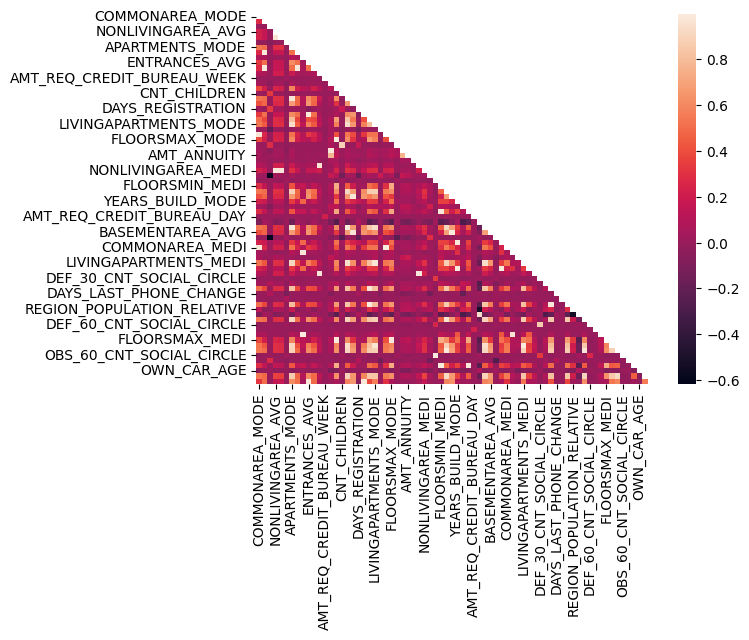

In [20]:
# корреляции признаков в основном датасете
binary_cols_proposal, categorical_cols_proposal, numerical_cols_proposal = columns_types_assumption(app_train)
corr_columns = list(set(numerical_cols_proposal)-set(['TARGET','SK_ID_CURR']))
corr_matrix = app_train[corr_columns].corr(numeric_only = True, method='pearson')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,mask=mask)

In [21]:
# credit ratios
app_train_orig = app_train.copy()
app_train_orig['APPS_ANNUITY_CREDIT_RATIO'] = app_train_orig['AMT_ANNUITY']/app_train_orig['AMT_CREDIT']
app_train_orig['APPS_EXT_SOURCE_MEAN'] = app_train_orig[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis = 1)
app_train_orig['APPS_EXT_SOURCE_STD'] = app_train_orig[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1)
app_train_orig['APPS_EXT_SOURCE_STD'] = app_train_orig['APPS_EXT_SOURCE_STD'].fillna(app_train_orig['APPS_EXT_SOURCE_STD'].mean())
app_train_orig['APPS_GOODS_CREDIT_RATIO'] = app_train_orig['AMT_GOODS_PRICE']/app_train_orig['AMT_CREDIT']
app_train_orig['APPS_ANNUITY_INCOME_RATIO'] = app_train_orig['AMT_ANNUITY']/app_train_orig['AMT_INCOME_TOTAL']
app_train_orig['APPS_INCOME_EMPLOYED_RATIO'] = app_train_orig['AMT_INCOME_TOTAL']/app_train_orig['DAYS_EMPLOYED']
app_train_orig['APPS_EMPLOYED_BIRTH_RATIO'] = app_train_orig['DAYS_EMPLOYED']/app_train_orig['DAYS_BIRTH']

app_train_orig['APPS_CAR_EMPLOYED_RATIO'] = app_train_orig['OWN_CAR_AGE'] / app_train_orig['DAYS_EMPLOYED']
app_train_orig['APPS_INCOME_BIRTH_RATIO'] = app_train_orig['AMT_INCOME_TOTAL']/app_train_orig['DAYS_BIRTH']

app_columns = app_train_orig.columns

In [22]:
app_train_orig.isna().sum().sum() / app_train_orig.size

0.2322480811894745

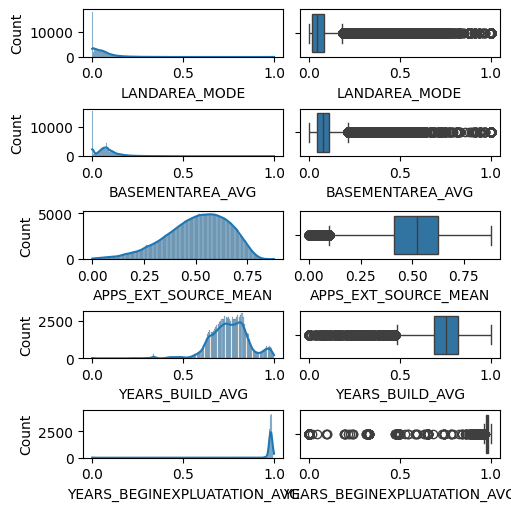

In [23]:
# Графики распределения переменных и "ящики с усами"
float_cols = [cname for cname in app_train_orig.columns if app_train_orig[cname].dtype in ['float64']]

plot_feat = list(set(float_cols)&set(app_columns) - set('SK_ID_CURR'))
# bureau_active_agg_cols.drop(['SK_ID_CURR'])[:5]
fig, axes = plt.subplots(5, 2, figsize=(5, 5),constrained_layout=True)
for k, column in enumerate(plot_feat[15:20]):    
    sns.histplot(data=app_train_orig, x=column, kde=True, ax=axes[k, 0])
    sns.boxplot(data=app_train_orig, x=column, ax=axes[k, 1])
# plt.tight_layout()
plt.show()

### Бюро кредитных историй bureau_df

In [24]:
# difference and date ratio between the planned debt start and completion date and the actual debt completion date
bureau_df['BUREAU_ENDDATE_FACT_DIFF'] = bureau_df['DAYS_CREDIT_ENDDATE'] - bureau_df['DAYS_ENDDATE_FACT']
bureau_df['BUREAU_CREDIT_FACT_DIFF'] = bureau_df['DAYS_CREDIT'] - bureau_df['DAYS_ENDDATE_FACT']
bureau_df['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau_df['DAYS_CREDIT'] - bureau_df['DAYS_CREDIT_ENDDATE']

bureau_df['BUREAU_CREDIT_DEBT_RATIO']=bureau_df['AMT_CREDIT_SUM_DEBT']/bureau_df['AMT_CREDIT_SUM']
bureau_df['BUREAU_CREDIT_DEBT_DIFF'] = bureau_df['AMT_CREDIT_SUM_DEBT'] - bureau_df['AMT_CREDIT_SUM']

bureau_df['BUREAU_IS_DPD'] = bureau_df['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
bureau_df['BUREAU_IS_DPD_OVER120'] = bureau_df['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x >120 else 0)

In [25]:
# аггрегированные показатели
bureau_agg_dict = {
'SK_ID_BUREAU':['count'],
'DAYS_CREDIT':['min', 'max', 'mean'],
'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
'AMT_ANNUITY': ['max', 'mean', 'sum'],

'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
'BUREAU_IS_DPD':['mean', 'sum'],
'BUREAU_IS_DPD_OVER120':['mean', 'sum']
}

bureau_grp = bureau_df.groupby('SK_ID_CURR')
bureau_amt_agg = bureau_grp.agg(bureau_agg_dict)
bureau_amt_agg.columns = ['BUREAU_'+('_').join(column).upper() for column in bureau_amt_agg.columns.ravel()]
bureau_amt_agg = bureau_amt_agg.reset_index()

In [26]:
bureau_amt_agg_cols = bureau_amt_agg.columns

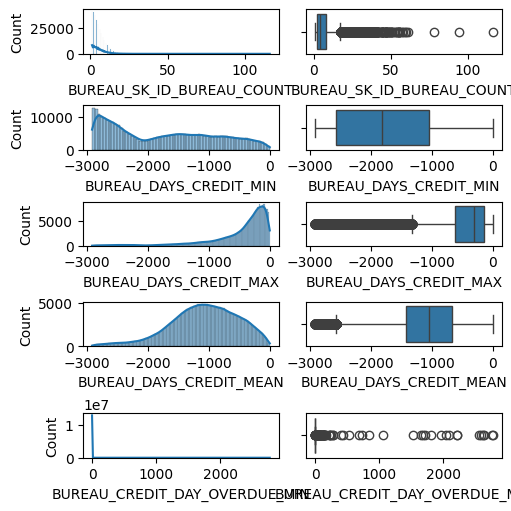

In [27]:
# Графики распределения переменных и "ящики с усами"

# bureau_active_agg_cols.drop(['SK_ID_CURR'])[:5]
fig, axes = plt.subplots(5, 2, figsize=(5, 5),constrained_layout=True)
for k, column in enumerate(bureau_amt_agg_cols.drop(['SK_ID_CURR'])[:5]):    
    sns.histplot(data=bureau_amt_agg, x=column, kde=True, ax=axes[k, 0])
    sns.boxplot(data=bureau_amt_agg, x=column, ax=axes[k, 1])
# plt.tight_layout()
plt.show()

In [28]:
# аггрегированные, касающиеся только активных кредитов  
cond_active = bureau_df['CREDIT_ACTIVE'] == 'Active'
bureau_active_grp = bureau_df[cond_active].groupby(['SK_ID_CURR'])
bureau_agg_dict = {
    'SK_ID_BUREAU':['count'],
    'DAYS_CREDIT':['min', 'max', 'mean'],
    'CREDIT_DAY_OVERDUE':['min', 'max', 'mean'],
    'DAYS_CREDIT_ENDDATE':['min', 'max', 'mean'],
    'DAYS_ENDDATE_FACT':['min', 'max', 'mean'],
    'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean'],
    'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
    'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
    'AMT_ANNUITY': ['max', 'mean', 'sum'],    
    'BUREAU_ENDDATE_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_FACT_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_ENDDATE_DIFF':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_RATIO':['min', 'max', 'mean'],
    'BUREAU_CREDIT_DEBT_DIFF':['min', 'max', 'mean'],
    'BUREAU_IS_DPD':['mean', 'sum'],
    'BUREAU_IS_DPD_OVER120':['mean', 'sum']
    }
bureau_active_agg = bureau_active_grp.agg(bureau_agg_dict)
bureau_active_agg.columns = ['BUREAU_ACT_'+('_').join(column).upper() for column in bureau_active_agg.columns.ravel()]
bureau_active_agg = bureau_active_agg.reset_index()

In [29]:
bureau_active_agg_cols = bureau_active_agg.columns
bureau_active_agg.dtypes.value_counts()

float64    39
int64       8
Name: count, dtype: int64

In [30]:
len(bureau_active_agg_cols)

47

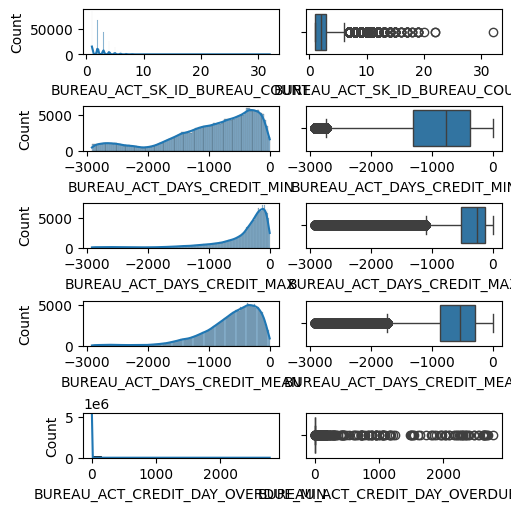

In [31]:
# Графики распределения переменных и "ящики с усами"

# bureau_active_agg_cols.drop(['SK_ID_CURR'])[:5]
fig, axes = plt.subplots(5, 2, figsize=(5, 5),constrained_layout=True)
for k, column in enumerate(bureau_active_agg_cols.drop(['SK_ID_CURR'])[:5]):    
    sns.histplot(data=bureau_active_agg, x=column, kde=True, ax=axes[k, 0])
    sns.boxplot(data=bureau_active_agg, x=column, ax=axes[k, 1])
# plt.tight_layout()
plt.show()

### Предыдущие заявки previous_application_df

In [32]:
# кредитные показатели для предыдущих заявок
previous_application_df['PREV_CREDIT_DIFF'] = previous_application_df['AMT_APPLICATION'] - previous_application_df['AMT_CREDIT']
previous_application_df['PREV_GOODS_DIFF'] = previous_application_df['AMT_APPLICATION'] - previous_application_df['AMT_GOODS_PRICE']
previous_application_df['PREV_CREDIT_APPL_RATIO'] = previous_application_df['AMT_CREDIT']/previous_application_df['AMT_APPLICATION']
previous_application_df['PREV_GOODS_APPL_RATIO'] = previous_application_df['AMT_GOODS_PRICE']/previous_application_df['AMT_APPLICATION']

# процентная ставка
previous_application_df['all_pay'] = previous_application_df['AMT_ANNUITY'] * previous_application_df['CNT_PAYMENT']
previous_application_df['PREV_INTERESTS_RATE'] = (previous_application_df['all_pay']/previous_application_df['AMT_CREDIT'] - 1)/previous_application_df['CNT_PAYMENT']

In [33]:
# аггрегированные показатели
agg_dict = {    
    'SK_ID_CURR':['count'],
    'AMT_CREDIT':['mean', 'max', 'sum'],
    'AMT_ANNUITY':['mean', 'max', 'sum'], 
    'AMT_APPLICATION':['mean', 'max', 'sum'],
    'AMT_DOWN_PAYMENT':['mean', 'max', 'sum'],
    'AMT_GOODS_PRICE':['mean', 'max', 'sum'],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
    'DAYS_DECISION': ['min', 'max', 'mean'],
    'CNT_PAYMENT': ['mean', 'sum'],
    'PREV_CREDIT_DIFF':['mean', 'max', 'sum'], 
    'PREV_CREDIT_APPL_RATIO':['mean', 'max'],
    'PREV_GOODS_DIFF':['mean', 'max', 'sum'],
    'PREV_GOODS_APPL_RATIO':['mean', 'max'],    
    'PREV_INTERESTS_RATE':['mean', 'max']
}

previous_application_group_df = previous_application_df.groupby('SK_ID_CURR')
previous_amt_agg = previous_application_group_df.agg(agg_dict)
previous_amt_agg.columns = ["PREV_"+ "_".join(x).upper() for x in previous_amt_agg.columns.ravel()]

In [34]:
# аггрегированные показатели отказов
prev_refused_appr_group = previous_application_df[previous_application_df['NAME_CONTRACT_STATUS'].isin(['Approved', 'Refused'])].groupby([ 'SK_ID_CURR', 'NAME_CONTRACT_STATUS'])
# unstack() 
prev_refused_appr_agg = prev_refused_appr_group['SK_ID_CURR'].count().unstack()

# rename column 
prev_refused_appr_agg.columns = ['PREV_APPROVED_COUNT', 'PREV_REFUSED_COUNT' ]
prev_refused_appr_agg = prev_refused_appr_agg.fillna(0)

# prev_refused_appr_agg

In [35]:
# соединяем агрегированные таблицы
prev_agg = previous_amt_agg.merge(prev_refused_appr_agg, on='SK_ID_CURR', how='left')
prev_agg['PREV_REFUSED_RATIO'] = prev_agg['PREV_REFUSED_COUNT']/prev_agg['PREV_SK_ID_CURR_COUNT']
prev_agg = prev_agg.drop(['PREV_REFUSED_COUNT', 'PREV_APPROVED_COUNT'], axis=1)

In [36]:
prev_agg_cols = prev_agg.columns
# prev_agg_cols

### Соединяем в один датасет

In [37]:
print('original dataset shape:', app_train.shape)
print('extended dataset shape:', app_train_orig.shape)

apps_all = app_train_orig.merge(prev_agg, on='SK_ID_CURR', how='left')
print('apps_all after merge with prev_agg shape:', apps_all.shape)
apps_all = apps_all.merge(bureau_amt_agg, on='SK_ID_CURR', how='left')
print('apps_all after merge with bureau_amt_agg shape:', apps_all.shape)
apps_all = apps_all.merge(bureau_active_agg, on='SK_ID_CURR', how='left')
print('apps_all after merge with bureau_active_agg shape:', apps_all.shape)

original dataset shape: (307511, 122)
extended dataset shape: (307511, 131)
apps_all after merge with prev_agg shape: (307511, 168)
apps_all after merge with bureau_amt_agg shape: (307511, 214)
apps_all after merge with bureau_active_agg shape: (307511, 260)


In [38]:
apps_all.isna().sum().sum() / apps_all.size

0.24702863662413077

### EDA расширенного датасета 

#### Предварительные преобразования

несколько базовых преобразований исходя из предыдущего анализа:
1. Меппинг CODE_GENDER
2. Бесконечные значения
3. Группировка OCCUPATION_TYPE, ORGANIZATION_TYPE

In [39]:
apps_all['CODE_GENDER'] = apps_all['CODE_GENDER'].map({'F': 1, 'M': 0, 'XNA': 1, 1: 1, 0: 0})

In [40]:
# Check for infinity
binary_cols_proposal, categorical_cols_proposal, numerical_cols_proposal = columns_types_assumption(apps_all)
print(np.isinf(apps_all[numerical_cols_proposal]).sum().sum()) # Count infinite values in each column
apps_all.replace([np.inf, -np.inf], np.nan, inplace=True)

201628


In [41]:
occupation_mapping = {
    "Laborers": "Low-Skilled Labor & Services",
    "Low-skill Laborers": "Low-Skilled Labor & Services",
    "Cleaning staff": "Low-Skilled Labor & Services",
    "Cooking staff": "Low-Skilled Labor & Services",
    "Waiters/barmen staff": "Low-Skilled Labor & Services",
    "Private service staff": "Low-Skilled Labor & Services",
    "Drivers": "Low-Skilled Labor & Services",
    "Security staff": "Low-Skilled Labor & Services",

    "Core staff": "Skilled Technical & Professional Roles",
    "Accountants": "Skilled Technical & Professional Roles",
    "Sales staff": "Skilled Technical & Professional Roles",
    "Medicine staff": "Skilled Technical & Professional Roles",
    "High skill tech staff": "Skilled Technical & Professional Roles",
    "IT staff": "Skilled Technical & Professional Roles",
    "Realty agents": "Skilled Technical & Professional Roles",
    "Secretaries": "Skilled Technical & Professional Roles",
    "HR staff": "Skilled Technical & Professional Roles",

    "Managers": "Management & Leadership"
}

if "OCCUPATION_TYPE" in apps_all.columns:
    apps_all['OCCUPATION_TYPE_GRP'] = apps_all['OCCUPATION_TYPE'].map(occupation_mapping)
    apps_all.drop(columns='OCCUPATION_TYPE',inplace=True)


In [42]:
category_mapping = {
    "Government": "Public Services",
    "Security Ministries": "Public Services",
    "Police": "Public Services",
    "Military": "Public Services",
    "Emergency": "Public Services",
    "Postal": "Public Services",
    
    "School": "Education",
    "Kindergarten": "Education",
    "University": "Education",

    "Medicine": "Healthcare",
    
    "Trade: type 1": "Trade & Retail",
    "Trade: type 2": "Trade & Retail",
    "Trade: type 3": "Trade & Retail",
    "Trade: type 4": "Trade & Retail",
    "Trade: type 5": "Trade & Retail",
    "Trade: type 6": "Trade & Retail",
    "Trade: type 7": "Trade & Retail",

    "Transport: type 1": "Transportation",
    "Transport: type 2": "Transportation",
    "Transport: type 3": "Transportation",
    "Transport: type 4": "Transportation",

    "Industry: type 1": "Industry & Manufacturing",
    "Industry: type 2": "Industry & Manufacturing",
    "Industry: type 3": "Industry & Manufacturing",
    "Industry: type 4": "Industry & Manufacturing",
    "Industry: type 5": "Industry & Manufacturing",
    "Industry: type 6": "Industry & Manufacturing",
    "Industry: type 7": "Industry & Manufacturing",
    "Industry: type 8": "Industry & Manufacturing",
    "Industry: type 9": "Industry & Manufacturing",
    "Industry: type 10": "Industry & Manufacturing",
    "Industry: type 11": "Industry & Manufacturing",
    "Industry: type 12": "Industry & Manufacturing",
    "Industry: type 13": "Industry & Manufacturing",
    "Construction": "Industry & Manufacturing",

    "Bank": "Finance & Business",
    "Insurance": "Finance & Business",
    "Legal Services": "Finance & Business",
    "Business Entity Type 1": "Finance & Business",
    "Business Entity Type 2": "Finance & Business",
    "Business Entity Type 3": "Finance & Business",
    "Realtor": "Finance & Business",

    "Self-employed": "Self-Employment & Services",
    "Cleaning": "Self-Employment & Services",
    "Security": "Self-Employment & Services",
    "Advertising": "Self-Employment & Services",
    "Telecom": "Self-Employment & Services",
    "Mobile": "Self-Employment & Services",

    "Hotel": "Hospitality & Leisure",
    "Restaurant": "Hospitality & Leisure",
    "Culture": "Hospitality & Leisure",

    "Electricity": "Energy & Utilities",
    
    "Other": "Other / Unknown",
    "XNA": "Other / Unknown"
}

if "ORGANIZATION_TYPE" in apps_all.columns:
    apps_all['ORGANIZATION_TYPE_GRP'] = apps_all['ORGANIZATION_TYPE'].map(category_mapping)
    apps_all.drop(columns='ORGANIZATION_TYPE',inplace=True)

### типы данных

In [43]:
apps_all.dtypes.value_counts()

float64    203
int64       42
object      15
Name: count, dtype: int64

In [44]:
binary_cols_proposal, categorical_cols_proposal, numerical_cols_proposal = columns_types_assumption(apps_all)
print(len(apps_all.columns))
print(len(binary_cols_proposal)+len(categorical_cols_proposal)+len(numerical_cols_proposal))
print(list(set(binary_cols_proposal)&set(categorical_cols_proposal)&set(numerical_cols_proposal)))
print(list(set(apps_all)-set(binary_cols_proposal)-set(categorical_cols_proposal)-set(numerical_cols_proposal)))

260
260
[]
[]


проверилил, что все колонки разметились в один из типов

In [45]:
print(f"app features: {len(app_columns)}")
print(f"bureau_amt_agg features: {len(bureau_amt_agg_cols)}")
print(f"bureau_active_agg features: {len(bureau_active_agg_cols)}")
print(f"prev_agg features: {len(prev_agg_cols)}")

print(f"Total features: {len(app_columns)+len(bureau_amt_agg_cols) + len(bureau_active_agg_cols) + len(prev_agg_cols) - 3}")

app features: 131
bureau_amt_agg features: 47
bureau_active_agg features: 47
prev_agg features: 37
Total features: 259


### Обработка аномалий

метод межквартильного разброса

In [46]:
outlier_cols_IQR = []

for col in numerical_cols_proposal:  # Consider only numerical columns
    Q1 = apps_all[col].quantile(0.25)
    Q3 = apps_all[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = apps_all[(apps_all[col] < lower_bound) | (apps_all[col] > upper_bound)]
    
if not outliers.empty:
    outlier_cols_IQR.append(col)   


In [47]:
print(f"Columns with outliers (IRQ method):\n{outlier_cols_IQR}")


Columns with outliers (IRQ method):
['BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM']


In [48]:
from scipy.stats import zscore

threshold=3
outlier_cols_Z_sc = []

for col in numerical_cols_proposal:  # Consider only numerical columns
    z_scores = zscore(apps_all[col].dropna())  # Drop NaNs to avoid errors
    if (abs(z_scores) > threshold).sum() > 0:
        outlier_cols_Z_sc.append(col)    

In [49]:
print(f"Columns with outliers (Z-score method):\n{outlier_cols_Z_sc}")
print(len(outlier_cols_Z_sc))

Columns with outliers (Z-score method):
['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDA

In [50]:
apps_all, perc_of_outliers = cap_outliers_3sigma(apps_all, outlier_cols_IQR)
perc_of_outliers

BUREAU_ACT_BUREAU_IS_DPD_OVER120_SUM    0.267308
Name: Outlier Percentage, dtype: float64

In [51]:
# # A value above 1 or below -1 indicates strong skewness.
# skewed_cols = apps_all[numerical_cols_proposal].skew()  # Compute absolute skewness

# # Highly positively skewed
# print(skewed_cols[skewed_cols > 2])

# # Highly negatively skewed
# print(skewed_cols[skewed_cols < -2])

### Корреляции

<Axes: >

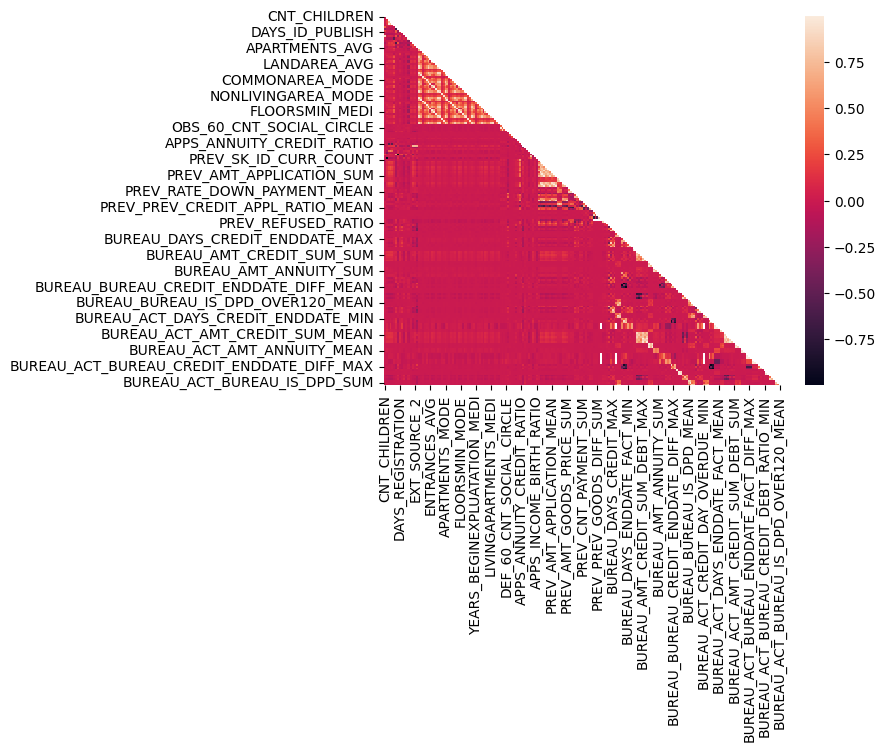

In [52]:
binary_cols_proposal, categorical_cols_proposal, numerical_cols_proposal = columns_types_assumption(apps_all)
corr_columns1 = numerical_cols_proposal.copy()
if 'TARGET' in corr_columns1:
    corr_columns1.remove('TARGET')
if 'SK_ID_CURR' in corr_columns1:
    corr_columns1.remove('SK_ID_CURR')

# корреляции признаков в основном датасете
corr_matrix = apps_all[corr_columns1].corr(numeric_only = True, method='pearson')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,mask=mask)

<Axes: >

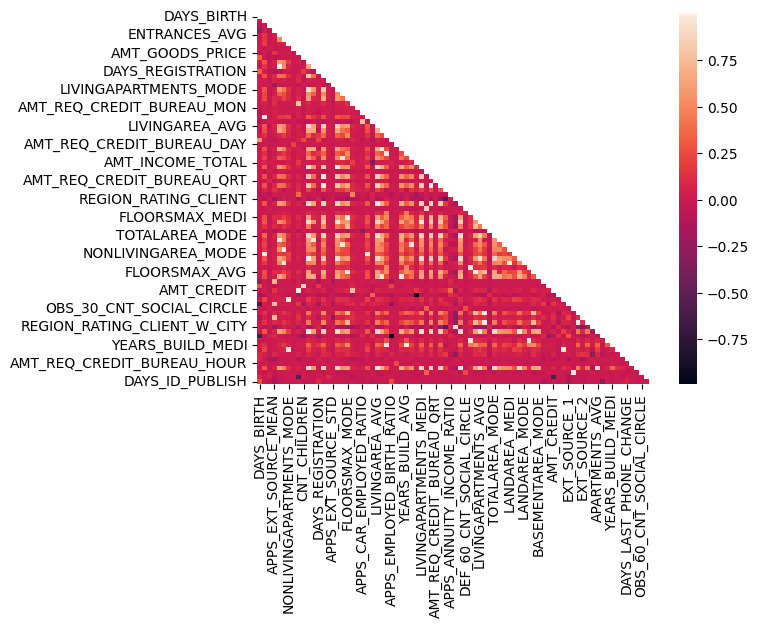

In [53]:
# корреляции признаков в основном датасете
corr_columns = list(set(corr_columns1)&set(app_train_orig.columns))
corr_matrix = app_train_orig[corr_columns].corr(numeric_only = True, method='pearson')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix,mask=mask)

In [54]:
# corr_matrix = apps_all[corr_columns].corr(numeric_only = True, method='pearson')
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
# sns.heatmap(corr_matrix,mask=mask)

In [55]:
# выводит самые коррелированные признаки
def feature_correlations(df, feature,method='pearson'):
    """
    Returns all correlations with the given feature, sorted in descending order.

    Parameters:
        df (pd.DataFrame): Input dataframe with numerical values.
        feature (str): The column name for which correlations should be calculated.

    Returns:
        pd.Series: A sorted series of correlations with the given feature.
    """
    if feature not in df.columns:
        raise ValueError(f"Feature '{feature}' not found in dataframe.")
    
    correlations = df.corr(method=method)[feature].drop(feature)  # Compute correlations and remove self-correlation
    return correlations.abs().sort_values(ascending=False)  # Sort by absolute correlation

In [56]:
numerical_features = numerical_cols_proposal.copy()
if 'TARGET' not in numerical_features:
    numerical_features.append('TARGET')
if 'SK_ID_CURR' in numerical_features:
    numerical_features.remove('SK_ID_CURR')

target_corr_pearson_df = feature_correlations(apps_all[numerical_features],'TARGET')

In [57]:
target_corr_pearson_df.to_csv(FileOut+'target_corr_pearson_df.csv')

In [58]:
target_corr_pearson_df.head(10)

APPS_EXT_SOURCE_MEAN                0.222052
EXT_SOURCE_3                        0.178919
EXT_SOURCE_2                        0.160472
EXT_SOURCE_1                        0.155317
BUREAU_DAYS_CREDIT_MEAN             0.089729
DAYS_BIRTH                          0.078239
PREV_REFUSED_RATIO                  0.077642
BUREAU_DAYS_CREDIT_MIN              0.075248
PREV_PREV_CREDIT_APPL_RATIO_MEAN    0.066335
APPS_GOODS_CREDIT_RATIO             0.065407
Name: TARGET, dtype: float64

Сильных корреляций с целевым показателем нет, есть слабые корреляции (в диапазоне от 10 до 30%) для 4 переменных

### Заполнение пропусков

In [59]:
apps_all[['SK_ID_CURR','TARGET']].isna().sum()

SK_ID_CURR    0
TARGET        0
dtype: int64

In [60]:
binary_cols_proposal, categorical_cols_proposal, numerical_cols_proposal = columns_types_assumption(apps_all)
print(len(apps_all.columns))
print(len(binary_cols_proposal)+len(categorical_cols_proposal)+len(numerical_cols_proposal))
print(list(set(binary_cols_proposal)&set(categorical_cols_proposal)&set(numerical_cols_proposal)))
print(list(set(apps_all)-set(binary_cols_proposal)-set(categorical_cols_proposal)-set(numerical_cols_proposal)))

260
260
[]
[]


In [61]:
from sklearn.impute import SimpleImputer

imputer_mean = SimpleImputer(strategy='mean')
imputer_most_frequent = SimpleImputer(strategy='most_frequent')

if 'TARGET' in binary_cols_proposal:
    binary_cols_proposal.remove('TARGET')
apps_all[binary_cols_proposal] = imputer_most_frequent.fit_transform(apps_all[binary_cols_proposal])
apps_all[categorical_cols_proposal] = imputer_most_frequent.fit_transform(apps_all[categorical_cols_proposal])
apps_all[numerical_cols_proposal] = imputer_mean.fit_transform(apps_all[numerical_cols_proposal])

In [62]:
apps_all.isna().sum().sum()

0

осталось ноль нулевых значений. Успех!

### Стандартизация

In [63]:
apps_all.dtypes.value_counts()

float64    210
object      49
int64        1
Name: count, dtype: int64

In [64]:
object_columns = apps_all.dtypes[apps_all.dtypes == 'object'].index.tolist()
#### One Hote Encoding
from sklearn.preprocessing import OneHotEncoder

# Initialize encoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Transform and create a new DataFrame
encoded_array = encoder.fit_transform(apps_all[object_columns])

# Get new column names
encoded_col_names = encoder.get_feature_names_out(object_columns)

# Drop original categorical columns from df
apps_all.drop(columns=object_columns, inplace=True)

# Add the encoded values as new columns
apps_all[encoded_col_names] = encoded_array

In [65]:
apps_all['SK_ID_CURR'] = apps_all['SK_ID_CURR'].astype(int)
apps_all['SK_ID_CURR'].dtype

dtype('int32')

In [66]:
apps_all.dtypes.value_counts()

float64    303
int32        1
int64        1
Name: count, dtype: int64

### Сохраняем очищенный датасет на диск

In [67]:
# apps_all.to_csv('../output/preprocessed_train_dataset.csv',index=False)

## Классификаторы

In [68]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, precision_score,recall_score, f1_score
# функция, чтобы считать сразу несколько метрик качества
def get_metrics(y_true, y_pred, y_proba):
    return {
        "AUC-ROC": roc_auc_score(y_true, y_proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred)
    }

In [69]:
import re
apps_all.columns = [re.sub(r'[\{\}\[\]:,"\`]', '', col) for col in apps_all.columns]

In [70]:
from sklearn.model_selection import train_test_split

apps_all_train, apps_all_test = train_test_split(apps_all,train_size=0.7, test_size=0.3,random_state=2025
                                                 ,stratify=apps_all['TARGET'])

X = apps_all_train.drop(['TARGET','SK_ID_CURR'], axis=1).copy()
y = apps_all_train['TARGET']

X_test = apps_all_test.drop(['TARGET','SK_ID_CURR'], axis=1).copy()
y_test = apps_all_test['TARGET']

### Dummy классификаторы (базовые)

In [71]:
from sklearn.dummy import DummyClassifier
dummy_most_freq = DummyClassifier(strategy="most_frequent")
dummy_rnd = DummyClassifier(strategy="stratified",random_state=2025)

In [72]:
X_test = apps_all_test.drop(['SK_ID_CURR', 'TARGET'], axis=1).fillna(0)
y_test = apps_all_test['TARGET']

dummy_rnd.fit(X, y)
y_pred_proba = dummy_rnd.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = dummy_rnd.predict(X_test)
metrics_dummy_random = get_metrics(y_test, y_pred, y_pred_proba)

dummy_most_freq.fit(X, y)
y_pred_proba = dummy_most_freq.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = dummy_most_freq.predict(X_test)
metrics_dummy_most_freq = get_metrics(y_test, y_pred, y_pred_proba)

metrics_df  = pd.DataFrame([metrics_dummy_most_freq, metrics_dummy_random], index=["Dummy_freq", "Dummy_random"])

# Round values for better readability
metrics_df  = metrics_df .round(4)
metrics_df
# print(f"{confusion_matrix(y_test, y_pred)}")
# print(classification_report(y_test, y_pred))

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Dummy_freq,0.500,0.9193,0.0000,0.0000,0.0000
Dummy_random,0.501,0.8504,0.0826,0.0843,0.0834


In [73]:
# Display summary table
metrics_df.to_csv(FileOut+'Dummies.csv')
metrics_df

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Dummy_freq,0.500,0.9193,0.0000,0.0000,0.0000
Dummy_random,0.501,0.8504,0.0826,0.0843,0.0834


### Light Gradient-Boosting Machine

In [74]:
from lightgbm import LGBMClassifier

In [75]:
def train_LGBMC(apps_all_train,n_estimators=1000):
    X = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1)
    y = apps_all_train['TARGET']

    X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.8, test_size=0.2,random_state=2025)
                                                        
    print('train shape:', X_train.shape, 'text shape:', X_test.shape)
    clf = LGBMClassifier(
                nthread=4,
                n_estimators=n_estimators, # 2000,
                learning_rate=0.02,
                max_depth = 5,
                silent=-1,
                verbose=-1
                )
   
    clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric= 'auc')
    # , verbose= 100,early_stopping_rounds= 200)
    
    return clf

обучаемся

In [76]:
clf = train_LGBMC(apps_all_train,n_estimators=1500)

train shape: (172205, 303) text shape: (43052, 303)


считаем метрики

In [77]:
apps_all_train.shape

(215257, 305)

In [78]:
X_test = apps_all_test.drop(['SK_ID_CURR', 'TARGET'], axis=1).fillna(0)
y_test = apps_all_test['TARGET']

y_pred_proba = clf.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = clf.predict(X_test)

X_train = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1).fillna(0)
y_train = apps_all_train['TARGET']

y_pred_proba_train = clf.predict_proba(X_train)[:, 1]  # Probabilities for class 1
y_pred_train = clf.predict(X_train)

# Compute metrics for train and test sets
metrics_train = get_metrics(y_train, y_pred_train, y_pred_proba_train)
metrics_test = get_metrics(y_test, y_pred, y_pred_proba)

metrics_df  = pd.DataFrame([metrics_train, metrics_test], index=["Train", "Test"])

# Round values for better readability
metrics_df  = metrics_df .round(4)
# print(f"{confusion_matrix(y_test, y_pred)}")
# print(classification_report(y_test, y_pred))

In [79]:
# Display summary table
metrics_df.to_csv(FileOut+'LightGBM.csv')
metrics_df

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Train,0.8637,0.9244,0.8456,0.0772,0.1415
Test,0.7818,0.9198,0.5490,0.0361,0.0678


Высокое значение AUC и низкое значение f1 может возникать из-за того, что датасет не сбалансирован и модель чаще предсказывает 0, чем 1.  
Один из способов это полечить - попробовать подобрать оптимальный порог для классификации на 0 и 1.  

In [80]:
# Get precision, recall, and thresholds
from sklearn.metrics import precision_recall_curve, f1_score
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Compute F1-scores for different thresholds
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-9)  # Avoid division by zero

# Find the best threshold
best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold for Best F1-score: {best_threshold:.3f}")

Optimal Threshold for Best F1-score: 0.160


In [81]:
y_pred_new = (y_pred_proba >= best_threshold).astype(int)
y_pred_train_new = (y_pred_proba_train >= best_threshold).astype(int)

# Compute metrics for train and test sets
metrics_train = get_metrics(y_train, y_pred_train_new, y_pred_proba_train)
metrics_test = get_metrics(y_test, y_pred_new, y_pred_proba)

metrics_df  = pd.DataFrame([metrics_train, metrics_test], index=["Train", "Test"])

# Round values for better readability
metrics_df  = metrics_df .round(4)

print(f"{confusion_matrix(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

[[84585   221]
 [ 7179   269]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84806
           1       0.55      0.04      0.07      7448

    accuracy                           0.92     92254
   macro avg       0.74      0.52      0.51     92254
weighted avg       0.89      0.92      0.89     92254



In [82]:
# Display summary table
metrics_df.to_csv(FileOut+'LightGBM_threshold.csv')
metrics_df

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Train,0.8637,0.8811,0.3556,0.5817,0.4414
Test,0.7818,0.8602,0.2726,0.4385,0.3362


Значение f1 на классе "1" увеличилось с 0.07 до 0.34
Попробуем другой способ - ребалансировать исходный датасет.  

метод - RandomUnderSampler, т.е. сокращение частотного класса

In [83]:
from imblearn.under_sampling import RandomUnderSampler

X = apps_all_train.drop(['TARGET'], axis=1).copy()
y = apps_all_train['TARGET']

rus = RandomUnderSampler(sampling_strategy='auto', random_state=2025)
X_resampled, y_resampled = rus.fit_resample(X, y)

запускаем обучение той же модели, но на сбалансированном классе

In [84]:
apps_all_train_resampled = pd.concat([X_resampled, y_resampled], axis=1)
print(apps_all_train.shape)
print(apps_all_train_resampled.shape)

(215257, 305)
(34754, 305)


In [85]:
clf_resample = train_LGBMC(apps_all_train_resampled,n_estimators=1500)

train shape: (27803, 303) text shape: (6951, 303)


In [85]:
X_test = apps_all_test.drop(['SK_ID_CURR', 'TARGET'], axis=1).fillna(0)
y_test = apps_all_test['TARGET']

y_pred_proba = clf_resample.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = clf_resample.predict(X_test)

X_train = apps_all_train.drop(['SK_ID_CURR', 'TARGET'], axis=1).fillna(0)
y_train = apps_all_train['TARGET']

y_pred_proba_train = clf_resample.predict_proba(X_train)[:, 1]  # Probabilities for class 1
y_pred_train = clf_resample.predict(X_train)

# Compute metrics for train and test sets
metrics_train = get_metrics(y_train, y_pred_train, y_pred_proba_train)
metrics_test = get_metrics(y_test, y_pred, y_pred_proba)

metrics_df  = pd.DataFrame([metrics_train, metrics_test], index=["Train", "Test"])

# Round values for better readability
metrics_df  = metrics_df .round(4)

# print(f"{confusion_matrix(y_test, y_pred)}")
# print(classification_report(y_test, y_pred))

In [86]:
# Display summary table
metrics_df .to_csv(FileOut+'LightGBM_resample.csv')
metrics_df

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Train,0.8402,0.7220,0.1993,0.8102,0.3199
Test,0.7754,0.7051,0.1734,0.7042,0.2783


вывод: балансировка тренировочного датасета методом undersampling улучшает показатели полноты и метрику f1

### Наиболее значимые переменные

In [89]:
feature_importance = pd.DataFrame({
    "Feature": apps_all_train.columns.drop(['SK_ID_CURR', 'TARGET']),
    "Importance": clf_resample.feature_importances_ 
})

# Sort by importance
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

In [90]:
most_important_features_csv = os.path.join(FileOut, "most_important_features50.csv")
most_important_features = feature_importance['Feature'][:50].values
most_important_features_df = pd.DataFrame(most_important_features, columns=["features"])
most_important_features_df.to_csv(most_important_features_csv, index=False)
reduced_features = list(most_important_features) + ['SK_ID_CURR', 'TARGET']

In [91]:
from lightgbm import plot_importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

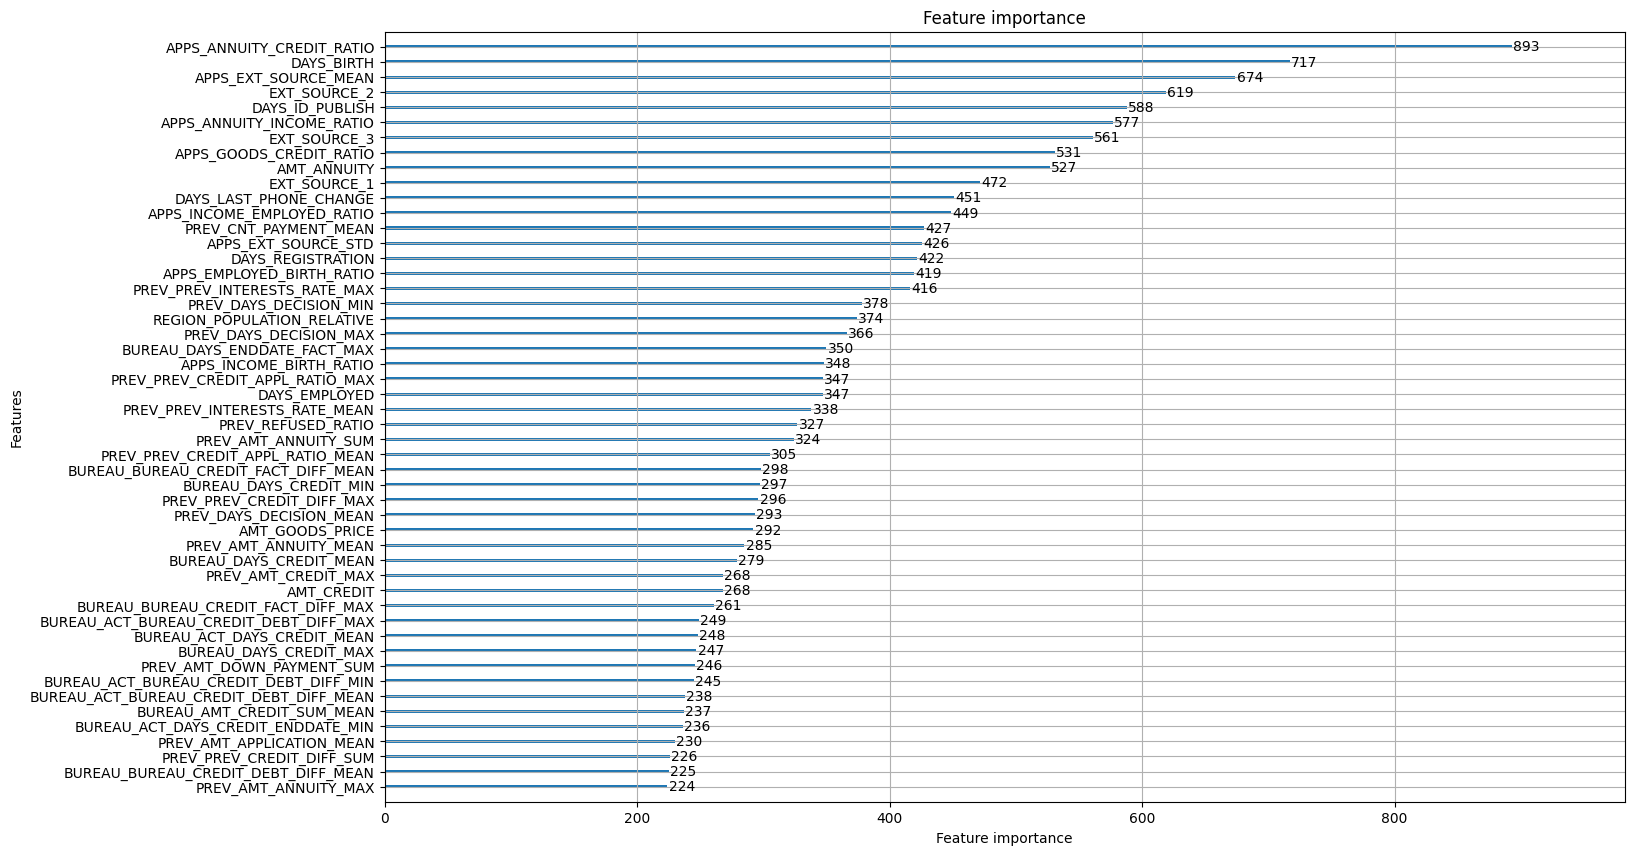

In [92]:
plot_importance(clf_resample, figsize=(16, 10), max_num_features=50)

### Light GBM with most important features

In [93]:
clf_resample = train_LGBMC(apps_all_train_resampled[reduced_features],n_estimators=1500)

train shape: (27803, 50) text shape: (6951, 50)


In [94]:
X_test = apps_all_test[reduced_features].drop(['SK_ID_CURR', 'TARGET'], axis=1).fillna(0)
y_test = apps_all_test['TARGET']

y_pred_proba = clf_resample.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = clf_resample.predict(X_test)

X_train = apps_all_train[reduced_features].drop(['SK_ID_CURR', 'TARGET'], axis=1).fillna(0)
y_train = apps_all_train['TARGET']

y_pred_proba_train = clf_resample.predict_proba(X_train)[:, 1]  # Probabilities for class 1
y_pred_train = clf_resample.predict(X_train)

# Compute metrics for train and test sets
metrics_train = get_metrics(y_train, y_pred_train, y_pred_proba_train)
metrics_test = get_metrics(y_test, y_pred, y_pred_proba)

metrics_df  = pd.DataFrame([metrics_train, metrics_test], index=["Train", "Test"])

# Round values for better readability
metrics_df  = metrics_df .round(4)

# print(f"{confusion_matrix(y_test, y_pred)}")
# print(classification_report(y_test, y_pred))
metrics_df .to_csv(FileOut+'LightGBM_most_important_features.csv')
metrics_df

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Train,0.8286,0.7166,0.1933,0.7910,0.3107
Test,0.7676,0.7013,0.1704,0.6979,0.2739


### Grid Search для дерева решений

In [95]:
X = apps_all_train[reduced_features].drop(['TARGET','SK_ID_CURR'], axis=1).copy()
y = apps_all_train['TARGET']

X_test = apps_all_test[reduced_features].drop(['TARGET','SK_ID_CURR'], axis=1).copy()
y_test = apps_all_test['TARGET']

In [96]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(class_weight="balanced")

# Определение параметров для подбора
param_grid = {
    'criterion': ['gini', 'entropy'],  # Функция для измерения качества разбиения
    'max_depth': [3, 5, 10, None]  # Глубина дерева
    # ,'min_samples_split': [2, 5, 10],  # Минимальное количество образцов для разбиения узла
    # 'min_samples_leaf': [1, 2, 5, 10]  # Минимальное количество образцов в листе
}

grid_search = GridSearchCV(model, param_grid, cv=10, scoring="f1", n_jobs=-1, verbose=100)
grid_search.fit(X, y)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best F1-score:", grid_search.best_score_)

Fitting 10 folds for each of 8 candidates, totalling 80 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 5}
Best F1-score: 0.24438836720716894


### Дерево решений

In [97]:
model = DecisionTreeClassifier(class_weight="balanced",max_depth = 5,criterion='entropy')
model.fit(X, y)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=5)

In [98]:
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = model.predict(X_test)

y_pred_proba_train = model.predict_proba(X)[:, 1]  # Probabilities for class 1
y_pred_train = model.predict(X)

# Compute metrics for train and test sets
metrics_train = get_metrics(y, y_pred_train, y_pred_proba_train)
metrics_test = get_metrics(y_test, y_pred_new, y_pred_proba)

metrics_df  = pd.DataFrame([metrics_train, metrics_test], index=["Train", "Test"])

# Round values for better readability
metrics_df  = metrics_df .round(4)

# Display summary table
metrics_df .to_csv(FileOut+'Decision_tree.csv')
metrics_df

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Train,0.7294,0.6835,0.1550,0.6562,0.2508
Test,0.7278,0.8602,0.2726,0.4385,0.3362


In [99]:
metrics_df

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Train,0.7294,0.6835,0.1550,0.6562,0.2508
Test,0.7278,0.8602,0.2726,0.4385,0.3362


In [100]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(X, y)

RandomForestClassifier()

In [101]:
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = model.predict(X_test)

print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"accuracy score: {accuracy_score(y_test, y_pred):.4f}")
print(f"precision score: {precision_score(y_test, y_pred):.4f}")
print(f"recall score: {recall_score(y_test, y_pred):.4f}")
print(f"f1 score: {f1_score(y_test, y_pred):.4f}")
print(f"{confusion_matrix(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

AUC-ROC Score: 0.7242
accuracy score: 0.9194
precision score: 0.5446
recall score: 0.0082
f1 score: 0.0161
[[84755    51]
 [ 7387    61]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84806
           1       0.54      0.01      0.02      7448

    accuracy                           0.92     92254
   macro avg       0.73      0.50      0.49     92254
weighted avg       0.89      0.92      0.88     92254



повторим то же самое с resampling

In [102]:
X = apps_all_train_resampled.drop(['TARGET','SK_ID_CURR'], axis=1).copy()
y = apps_all_train_resampled['TARGET']

X_test = apps_all_test.drop(['TARGET','SK_ID_CURR'], axis=1).copy()
y_test = apps_all_test['TARGET']

model = RandomForestClassifier()
model.fit(X, y)

y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = model.predict(X_test)

print(f"AUC-ROC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
print(f"accuracy score: {accuracy_score(y_test, y_pred):.4f}")
print(f"precision score: {precision_score(y_test, y_pred):.4f}")
print(f"recall score: {recall_score(y_test, y_pred):.4f}")
print(f"f1 score: {f1_score(y_test, y_pred):.4f}")
print(f"{confusion_matrix(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

AUC-ROC Score: 0.7556
accuracy score: 0.7029
precision score: 0.1675
recall score: 0.6752
f1 score: 0.2684
[[59812 24994]
 [ 2419  5029]]
              precision    recall  f1-score   support

           0       0.96      0.71      0.81     84806
           1       0.17      0.68      0.27      7448

    accuracy                           0.70     92254
   macro avg       0.56      0.69      0.54     92254
weighted avg       0.90      0.70      0.77     92254



### Логистическая регрессия

In [103]:
X = apps_all_train[reduced_features].drop(['TARGET','SK_ID_CURR'], axis=1).copy()
y = apps_all_train['TARGET']

X_test = apps_all_test[reduced_features].drop(['TARGET','SK_ID_CURR'], axis=1).copy()
y_test = apps_all_test['TARGET']

In [104]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500,class_weight="balanced",penalty="l1",solver="liblinear",C=1)
model.fit(X, y)

LogisticRegression(C=1, class_weight='balanced', max_iter=500, penalty='l1',
                   solver='liblinear')

In [105]:
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = model.predict(X_test)

y_pred_proba_train = model.predict_proba(X)[:, 1]  # Probabilities for class 1
y_pred_train = model.predict(X)

# Compute metrics for train and test sets
metrics_train = get_metrics(y, y_pred_train, y_pred_proba_train)
metrics_test = get_metrics(y_test, y_pred, y_pred_proba)

metrics_df  = pd.DataFrame([metrics_train, metrics_test], index=["Train", "Test"])

# Round values for better readability
metrics_df  = metrics_df.round(4)

# Display summary table
metrics_df .to_csv(FileOut+'Logistic_regression.csv')
metrics_df

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Train,0.7453,0.6871,0.1596,0.6745,0.2581
Test,0.7488,0.6886,0.1606,0.6758,0.2595


In [106]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500,class_weight="balanced",solver="liblinear")
model.fit(X, y)

y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = model.predict(X_test)

y_pred_proba_train = model.predict_proba(X)[:, 1]  # Probabilities for class 1
y_pred_train = model.predict(X)

# Compute metrics for train and test sets
metrics_train = get_metrics(y, y_pred_train, y_pred_proba_train)
metrics_test = get_metrics(y_test, y_pred, y_pred_proba)

metrics_df  = pd.DataFrame([metrics_train, metrics_test], index=["Train", "Test"])

# Round values for better readability
metrics_df  = metrics_df.round(4)

# Display summary table
metrics_df .to_csv(FileOut+'Logistic_regression_no_regularisation.csv')
metrics_df

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Train,0.6607,0.6296,0.1259,0.6038,0.2084
Test,0.6664,0.6324,0.1283,0.6135,0.2123


### Adaboost and XGBoost

In [107]:
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

rus = RandomUnderSampler(sampling_strategy='auto', random_state=2025)
X_resampled, y_resampled = rus.fit_resample(X, y)

# Train AdaBoost
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(X_resampled, y_resampled)

y_pred_proba = ada.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = ada.predict(X_test)

y_pred_proba_train = ada.predict_proba(X)[:, 1]  # Probabilities for class 1
y_pred_train = ada.predict(X)

# Compute metrics for train and test sets
metrics_train = get_metrics(y, y_pred_train, y_pred_proba_train)
metrics_test = get_metrics(y_test, y_pred, y_pred_proba)

metrics_df  = pd.DataFrame([metrics_train, metrics_test], index=["Train", "Test"])

# Round values for better readability
metrics_df  = metrics_df.round(4)

# Display summary table
metrics_df

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Train,0.7603,0.6950,0.1657,0.6886,0.2672
Test,0.7577,0.6953,0.1659,0.6886,0.2674


In [108]:
# Train XGBoost
xgb = XGBClassifier(n_estimators=100, scale_pos_weight=11, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb.fit(X, y)

y_pred_proba = xgb.predict_proba(X_test)[:, 1]  # Probabilities for class 1
y_pred = xgb.predict(X_test)

y_pred_proba_train = xgb.predict_proba(X)[:, 1]  # Probabilities for class 1
y_pred_train = xgb.predict(X)

# Compute metrics for train and test sets
metrics_train = get_metrics(y, y_pred_train, y_pred_proba_train)
metrics_test = get_metrics(y_test, y_pred, y_pred_proba)

metrics_df  = pd.DataFrame([metrics_train, metrics_test], index=["Train", "Test"])

# Round values for better readability
metrics_df  = metrics_df.round(4)

# Display summary table
metrics_df

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
Train,0.8980,0.8007,0.2663,0.8366,0.4040
Test,0.7565,0.7645,0.1889,0.5820,0.2852


### Cохраняем модель clf_resample для дальнейшего использования в приложении 

In [87]:
clf_resample.booster_.save_model(FileOut+"LightGBMmodel.txt")

In [89]:
# Если захотим применить обученную модель
# model = lgb.Booster(model_file="model.txt")
# clf = lgb.LGBMClassifier()
# clf._Booster = model